In [1]:
# General imports
import numpy as np
import pandas as pd
import networkx as nx
from copy import deepcopy

# Functions for the implementation of DebtRank
from network_helpers import(
    prepare_data_for_debtrank,
    get_adjacency_matrix,
    debtrank_dynamics,
    debtrank_calculate,
)

# Background

An example of the DebtRank algorithm (Battiston et. al., 2012) adapted to a case of firms conducting equity investments in other firms. Function for the implementation of DebtRank [here](https://github.com/vvoutilainen/Data_Science_Projects/blob/master/stats/network/network_helpers.py).

We begin by adopting the network structure of Figure 5 in the Supplementary Material in Battiston et. al. (2012). We flip the direction of edges and consider each edge `A -> B` to represent an equity investment: A has invested equity in firm B. That is, A has a claim on firm B's equity (asset of A). In some settings this can be thought of as firm A owning some part of firm B (a share of B's total equity). For ease of reference, here we refer to the entities as "source" and "target" entities.

Notice that in the original paper the interest is in contagion impact (exposure) between *banks* via assets (e.g., lending, bonds, stock shares) invested by bank $j$ in funding of bank $i$. Credit exposure arguably is the most important part, hence the name "DebtRank". As the authors lack credit exposure data, they use equity investments to construct a *proxy* of the overall exposure/impact. Here, we assume no other financial dependencies between the firms in the network. That is, distress between nodes is propagated only through the impact of diminishing values of asset values of equity investments. Hence, we do not have to bother with the normalizations of section "DebtRank. Empirical pplication." of the original paper. 

Distress of a node (or set of nodes) propagates "upstream" through the network. For example, if node B defaults, its equity is wiped out, and its source A will take a hit on its assets and hence equity. As in the original example of Figure 5, we consider a case where node 1 faces default (distress of 1).

Note: Bardoscia et. al. (2015) importantly point out that the way infinite reverberations are canceled out in the DebRank algorithm also means that a node is allowed to propagate shocks only the first time it receives them. This can lead to underestimation of losses.

**Sources**

 - Stefano Battiston, Michelangelo Puliga, Rahul Kaushik, Paolo Tasca & Guido Caldarelli (2012): [DebtRank: Too Central to Fail? Financial Networks, the FED and Systemic Risk](https://www.nature.com/articles/srep00541). Nature Scientific Reports. [Supplementary material](https://static-content.springer.com/esm/art%3A10.1038%2Fsrep00541/MediaObjects/41598_2012_BFsrep00541_MOESM1_ESM.pdf).
 - Battiston (2012): [DebtRank: Too central to fail?](https://www.cigionline.org/sites/default/files/shared/3c-stefano_battiston.pdf). INET-CIGI False Dichotomies.
 - Marco Bardoscia, Stefano Battiston, Fabio Caccioli & Guido Caldarelli (2015): [DebtRank: A Microscopic Foundation for Shock Propagation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130406#sec006). PLOS ONE.

# Notation and equations

We adapt the notation from Battiston et. al. (2012) to our case:

Let there be a set of nodes $S$ belonging to the system. Each node $k \in S$ represents a firm. A column pair $(j, i)$ represents an equity investment of source $j$ in $i$. Let $A_{ji}$ be the value of the equity investment. An equivalent interpretation is that $A_{ji}$ denotes the losses incurred by $j$ in the case of default of $i$. Further, let $E_j$ be the equity position of firm $j$ and $A_j = \sum_i A_{ji}$ the total value contributed by $j$ into investments. 

$W_{ij} = \text{min} \ \{1, \ \frac{A_{ji}}{E_j} \}$ denotes the impact of $i$ on $j$. Matrix $W$ is a $NxN$ matrix where rows represent targets ($i$) and columns sources ($j$). That is, a row $W_{i:}$ indicates target $i$'s impact on each other (source) node $j$. $W^T$ is the transpose of $W$: here each row (for $j$) denotes how much $j$ is impacted by each $i$ (columns).

Distress of node $k$ is measured by $h_k \in [0, 1]$. Dynamics for the distress are given by

\begin{align*}
h_j(t) = \text{min} \ \big\{ 1, \ h_j(t-1) + \sum_l W_{lj} \ h_l(t-1) \big\}
\end{align*}

where $j | s_j(t-1)=D$.

In the above, notice that $\sum_l W_{lj} \ h_l(t-1)$ is the dot-product of

 - each $j$th row of $W^T$ (i.e., $W^T_{j:}$; by how much $j$ is impacted by each $l$), and
 - $h_l(t-1)$ (the previous-period stress of each $l$);
 - **but** taking into account that only impact of such $l$ that in previous period had a status $D$ is considered.
 
Equivalently, we can set those columns in $W^T$ ($W^T_{:l}$) to zero whrere entity $l$'s state in previous period was not $D$.

The monetary value of the distress of node $k$ is obtained by multiplying $h_k$ with the relative economic value of $k$. It is defined as $v_k = A_k / \sum_k A_k$, that is, as the share of $k$'s investments compared to all investments. As the original paper notes, other proxies could be used, too.

Now, let nodes in set $S_f \subset S$ initially fall into distress of amount $\psi$. DebtRank is defined as

\begin{align*}
R = \sum_k h_k(T) v_k - \sum_k h_k(1) v_k
\end{align*}

That is, the DetRank measures the distress (i.e., economic loss measured as a fraction) induced into the system (distress of all nodes $k \in S$) by initial distress of nodes in set $S_f$, excluding the initial distress.

# Functions for preparation

In [2]:
def create_data():
    """Create network data for the example."""
    # Edges frame
    edges_list = [
        ("2", "1", 4),
        ("5", "2", 3),
        ("7", "5", 5),
        ("2", "5", 2),
        ("3", "1", 6),
        ("4", "1", 3),
        ("6", "4", 2),
        ("8", "6", 7),
        ("5", "6", 2),
    ]
    edges = pd.DataFrame(edges_list, columns=["source", "target", "equity_investment"])

    # Get total equities from equity investments
    equity = (
        pd.concat([
            edges
            .groupby("target")
            .agg(equity=("equity_investment", "sum")),
            # Append equity for nodes 3, 7 and 8, as no one has invested in it
            pd.DataFrame(
                data={"equity": [56, 90, 50]},
                index=["3", "7", "8"]
            )
        ])
        .reset_index()
        .rename(columns={"index": "node_id"})
        .sort_values("node_id")
        .set_index("node_id")
    )

    # Add some jitter to the equitites, so that the total equity is not always
    # fully detemined by the known investments in the network
    equity = equity.add([1, 3, 0, 6, 8, 0, 0, 0,], axis=0)

    # Nodes frame
    nodes = equity.copy()
    del equity

    # Create graph from edges list
    graph = nx.from_pandas_edgelist(
        edges,
        source="source",
        target="target",
        edge_attr=True,
        create_using=nx.DiGraph
    )

    # Set node attributes in graph
    nx.set_node_attributes(graph, nodes.to_dict("index"))

    return graph, edges, nodes

def draw_graph(graph):
    """Draw the graph"""
    # Node positions
    pos = {
        "1": np.array([1, 3]),
        "2": np.array([0, 2]),
        "3": np.array([1, 2]),
        "4": np.array([2, 2]),
        "5": np.array([0, 1]),
        "6": np.array([2, 1]),
        "7": np.array([0, 0]),
        "8": np.array([2, 0]),
    }

    # Draw nodes and node labels
    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_labels(graph, pos)

    # Draw edges
    nx.draw_networkx_edges(
        graph,
        pos,
        connectionstyle="arc3,rad=0.1",
    )

    # Draw edge labels (hacky way, makes the labels appear twice for straight edges
    _ = nx.draw_networkx_edge_labels(
        graph,
        pos,
        edge_labels=nx.get_edge_attributes(graph, "equity_investment"),
        label_pos=0.3,
    )
    _ = nx.draw_networkx_edge_labels(
        graph,
        pos,
        edge_labels=nx.get_edge_attributes(graph, "equity_investment"),
        label_pos=0.7,
    )

# Examples

First prepare the data and draw the network.

,equity,v_j
node_id,,
1,14,0.000000
2,6,0.176471
3,56,0.176471
4,8,0.088235
5,15,0.147059
6,9,0.058824
7,90,0.147059
8,50,0.205882


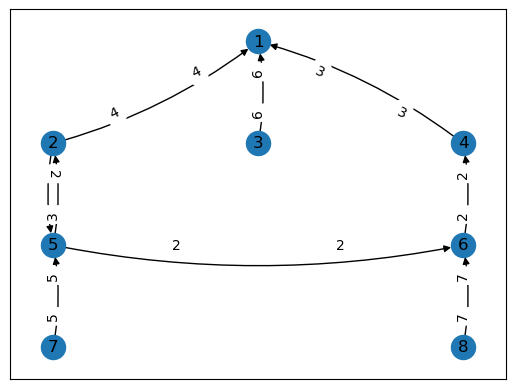

In [3]:
# Create edges frame data and construct a graph
graph, edges, nodes = create_data()

# Derive variables for DebtRank algorithm
edges, nodes = prepare_data_for_debtrank(edges, nodes)

# Create adjacency matrix
W_v1, ids = get_adjacency_matrix(edges)
#W_v1 = np.array(W_v1.todense())

# Version of W from Figure 5: all non-zero values in W are 0.5
W_v2 = deepcopy(W_v1)
W_v2[W_v2!=0] = 0.5

# Draw graph
draw_graph(graph)
display(nodes)

Run the DebtRank algorithm with the equity investment values from the network. 

In [4]:
distress = debtrank_dynamics(
    W_in=W_v1,
    ids=ids,
    S_f=["1",], # Entities that are initially stressed
)
display(distress)
print("DebtRank: {:.3f}".format(debtrank_calculate(distress, nodes)))

,h,s,h_init
node_id,,,
1,1.000000,I,1
2,0.711111,I,0
3,0.107143,I,0
4,0.375000,I,0
5,0.144444,I,0
6,0.083333,I,0
7,0.007407,I,0
8,0.011667,I,0


DebtRank: 0.207


Run the DebtRank algorithm with values of the impact matrix as in Figure 5 of the main reference supplementary material; that is, all impacts have been forced to 0.5.

In [5]:
distress = debtrank_dynamics(
    W_in=W_v2,
    ids=ids,
    S_f=["1",], # Entities that are initially stressed
)
display(distress)
print("DebtRank: {:.3f}".format(debtrank_calculate(distress, nodes)))

,h,s,h_init
node_id,,,
1,1.000,I,1
2,0.625,I,0
3,0.500,I,0
4,0.500,I,0
5,0.375,I,0
6,0.250,I,0
7,0.125,I,0
8,0.125,I,0


DebtRank: 0.357
